In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

def read_directory(directory_name):
    faces_addr=[]
    for filename in os.listdir(directory_name):
        faces_addr.append(directory_name+"/"+filename)
    return faces_addr

def split(train,test,all_images):
    for i in range(40):
        for j in range(7):
            train.append(all_images[i*10+j])
    train = np.array(train)
    for i in range(40):
        for j in range(7,10):
            test.append(all_images[i*10+j])
    test = np.array(test)
    return train,test

def show_faces(img):
    plt.imshow(img,cmap='gray')
    plt.show()


faces = []
for i in range(1, 41):
    faces_addr = read_directory('./ORL/s'+str(i))
    for addr in faces_addr:
        faces.append(addr)
        
images=[]
for index,face in enumerate(faces):
    image=cv2.imread(face,0)
    images.append(image)

all_images=[]
for image in images:
    data=image.flatten()
    all_images.append(data)
print(len(all_images))


train = []
test = []
train,test=split(train,test,all_images)
print(test.shape)
print(train.shape)

400
(120, 10304)
(280, 10304)


(10304,)
平均脸： [85.15       85.17857143 85.5        ... 74.72857143 73.89285714
 73.24285714]


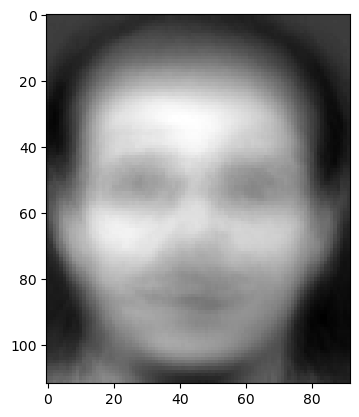

去中心化后的训练集： (10304, 280)
去中心化后的测试集： (10304, 120)


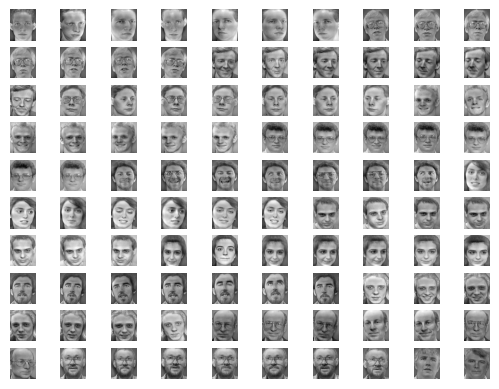

In [52]:
mean = np.mean(train, axis=0) #平均脸
print(mean.shape)
print("平均脸：",mean)
plt.imshow(mean.reshape(112,-1), cmap='gray')
plt.show()
train=(train-mean).T #去中心化(10304,280)
test=(test-mean).T #测试集按照训练集进行去中心化
print("去中心化后的训练集：",train.shape)
print("去中心化后的测试集：",test.shape)

fig, axs = plt.subplots(10, 10)

for i in range(100): #展示前100张训练集
    axs[i//10, i%10].imshow(train[:, i].reshape(112,-1), cmap='gray')
    axs[i//10, i%10].axis('off') #隐藏坐标轴

plt.show()

In [7]:
cov_train = np.cov(train)
eigen_values,eigen_vectors = np.linalg.eig(cov_train)
print("特征向量：", eigen_vectors.shape) #10304
print("特征值：", eigen_values.shape)

特征向量： (10304, 10304)
特征值： (10304,)


In [10]:
# 对特征值进行排序，获得排列后的特征值和索引
sorted_indices = np.argsort(eigen_values)[::-1]
print(sorted_indices)
sorted_eigen_values = eigen_values[sorted_indices]
print(sorted_eigen_values)
# 获取排序后特征值对应的特征向量
sorted_eigen_vectors = eigen_vectors[:,sorted_indices]
print(sorted_eigen_vectors.shape)

[  0   1   2 ... 285 279 280]
[ 2.88819848e+06+0.00000000e+00j  2.11458299e+06+0.00000000e+00j
  1.13117525e+06+0.00000000e+00j ... -1.22664267e-10+0.00000000e+00j
 -1.29638206e-10+7.44046691e-11j -1.29638206e-10-7.44046691e-11j]
(10304, 10304)


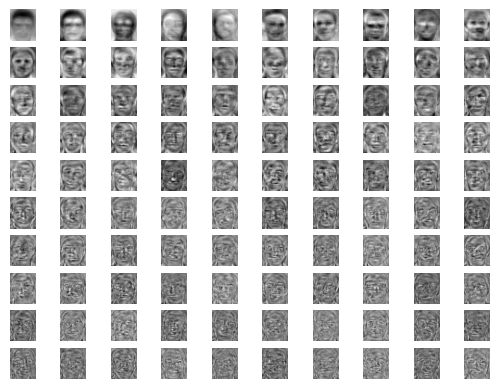

投影矩阵
(10304, 100)
[[ 0.00280687  0.01453773  0.02037881 ... -0.0031518  -0.00409063
   0.00319972]
 [ 0.00274588  0.01456024  0.02038967 ... -0.0038843  -0.00568619
   0.00295033]
 [ 0.00282587  0.01448154  0.02018167 ... -0.00066713 -0.00642367
   0.00014324]
 ...
 [ 0.00664635 -0.01075648  0.01107479 ...  0.01707846  0.01187121
  -0.01222572]
 [ 0.00613    -0.00969508  0.01147735 ...  0.00050914  0.00268909
  -0.01088144]
 [ 0.00684871 -0.00872317  0.01195645 ...  0.00097856 -0.00392212
  -0.00314276]]


In [44]:
#特征脸
fig, axs = plt.subplots(10, 10)

for i in range(100):
    axs[i//10, i%10].imshow(np.real(eigen_vectors[:, i]).reshape(112,-1), cmap='gray')
    axs[i//10, i%10].axis('off') #隐藏坐标轴

plt.show()
#保留前100个特征值和特征向量构成的特征脸
eigen_face=np.real(eigen_vectors[:,:100])
print('投影矩阵')
print(eigen_face.shape)
print(eigen_face)

In [54]:
#判断新人脸test,投影到脸空间
x=eigen_face.T@train #100*10314 10314*280=100*280 训练集降维后的数据
print(x.shape)
s={}
for i in range(40):
    s[i] = np.mean(x[:, 7*i:7*(i+1)], axis=1) #对同一张人的7张特征脸取平均，获得40张脸空间的向量
print(s[0].shape)


new_test=eigen_face.T@test #10304*100'10314*120=100*120
print(new_test.shape) #验证集降维之后的数据

def judge(a,s):
    index=0
    this_distance=float('inf')
    distance=0
    for k in range(40): #与40张脸空间比较，判断和哪张脸最近，返回索引
        distance=(s[k]-a).T@(s[k]-a)
        if this_distance>=distance:
            this_distance=distance
            index=k
    return index
    
#对测试集的120张人脸进行分类
judge_test={}
for i in range(40):
    for j in range(3):
        judge_test[i*3+j]=judge(new_test[:,i*3+j],s)
        
print(judge_test)

#计算准确率
cnt=0
for i in range(40):
    for j in range(3):
        if judge_test[i*3+j]==i:
            cnt=cnt+1
print("准确率：",cnt/120*100,"%")
        

(100, 280)
(100,)
(100, 120)
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4, 15: 5, 16: 5, 17: 5, 18: 6, 19: 6, 20: 6, 21: 7, 22: 7, 23: 7, 24: 8, 25: 8, 26: 8, 27: 9, 28: 9, 29: 9, 30: 10, 31: 10, 32: 10, 33: 11, 34: 11, 35: 11, 36: 12, 37: 12, 38: 12, 39: 13, 40: 13, 41: 13, 42: 14, 43: 14, 44: 14, 45: 15, 46: 26, 47: 15, 48: 16, 49: 16, 50: 16, 51: 17, 52: 17, 53: 17, 54: 18, 55: 18, 56: 15, 57: 19, 58: 19, 59: 19, 60: 20, 61: 20, 62: 20, 63: 21, 64: 21, 65: 21, 66: 22, 67: 22, 68: 22, 69: 23, 70: 23, 71: 23, 72: 24, 73: 24, 74: 24, 75: 27, 76: 25, 77: 25, 78: 10, 79: 26, 80: 26, 81: 27, 82: 36, 83: 27, 84: 28, 85: 28, 86: 28, 87: 29, 88: 29, 89: 29, 90: 20, 91: 8, 92: 20, 93: 1, 94: 31, 95: 31, 96: 32, 97: 32, 98: 32, 99: 33, 100: 33, 101: 33, 102: 24, 103: 34, 104: 34, 105: 35, 106: 35, 107: 35, 108: 36, 109: 36, 110: 36, 111: 37, 112: 37, 113: 37, 114: 38, 115: 38, 116: 38, 117: 39, 118: 39, 119: 4}
准确率： 90.83333333333333 %
